<a href="https://colab.research.google.com/github/YoungHyunKoo/GEE_remote_sensing/blob/main/Week3/3_1_Math_Operations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **[GEO 6083] Remote Sensing Imge Processing - Spring 2024**
# **WEEK 3-1. Math opereations**

### OBJECTIVES
1. Undestand and calculate NDVI and other indices.
2. Calculate regional statistics.
3. Apply terrain functions to elevation data.

Credited by Younghyun Koo (kooala317@gmail.com)


## **1. Calculate NDVI**

## How do math operations (or functions) work in GEE?
Earth Engine supports many basic mathmatical operators (e.g. `add`, `subtract`, `multiply`, `divide`, etc.). Earth Engine performs these math operators by pixel. When an operator is applied to a single image, it's applied to pixels of each band. In the case of operations on two different images, the operation is only applied at the location where pixels in both images are unmasked. When an operator is applied to two images, the images are expected to have the same number of bands and spatial resolutions so they can be matched pairwise. However, if one of the images has only a single band, it is matched with all of the bands in the other image, essentially replicating that band enough time to match the other image.

### **Import image collections**

In [ ]:
# Import ee library
import ee

# Authenticate
ee.Authenticate()

# Initialize with your own project.
ee.Initialize(project = "utsa-spring2024")

In [ ]:
# Import geemap library
import geemap

# Import os libray
import os

Let's import a image collection for a specific region and time we are interested in. Also, we will filter out the images with cloud covers less than 10 %. We already did how to filter out an image collection using `filterDate`, `filterBounds`, and `filterMetadata` functions.

In [ ]:
# Import image collection - Landsat 8 top of atmosphere reflectance
L8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
    .filterDate('2020-01-01', '2020-12-31') \
    .filterBounds(ee.Geometry.Point(-122.4488, 37.7589)) \
    .filterMetadata('CLOUD_COVER', 'less_than', 10) \
    .sort("CLOUD_COVER")

In [ ]:
# Get metadata information
L8.getInfo()

{'type': 'ImageCollection',
 'bands': [{'id': 'B1',
   'data_type': {'type': 'PixelType', 'precision': 'float'}},
  {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'float'}},
  {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'float'}},
  {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'float'}},
  {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'float'}},
  {'id': 'B6', 'data_type': {'type': 'PixelType', 'precision': 'float'}},
  {'id': 'B7', 'data_type': {'type': 'PixelType', 'precision': 'float'}},
  {'id': 'B8', 'data_type': {'type': 'PixelType', 'precision': 'float'}},
  {'id': 'B9', 'data_type': {'type': 'PixelType', 'precision': 'float'}},
  {'id': 'B10', 'data_type': {'type': 'PixelType', 'precision': 'float'}},
  {'id': 'B11', 'data_type': {'type': 'PixelType', 'precision': 'float'}},
  {'id': 'QA_PIXEL',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535}},
  {'id': 'QA_RADSAT',
   'd

In [ ]:
# First image of the L8 image collection
image = L8.first()

In [ ]:
# Load a geemap
Map = geemap.Map()

# image visualization factors
vis_param = {'min': 0,
             'max': 0.2,
             'bands': ['B4', 'B3', 'B2'],
             'gamma': 1.0}

# Just in case of surface reflectance image
# vis_param = {'min': 0,
#              'max': 15000,
#              'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
#              'gamma': 0.5}

Map.addLayer(image, vis_param, "First image")
Map.centerObject(image, 8)

Map

Map(center=[37.47163816407799, -122.11209670491242], controls=(WidgetControl(options=['position', 'transparent…

### **Use functions**

This is an image around San Francisco area. Now let's explore some band information of this image.

In [ ]:
# Band information as a list of dictinoary
image.getInfo()['bands']

[{'id': 'B1',
  'data_type': {'type': 'PixelType', 'precision': 'float'},
  'dimensions': [7671, 7811],
  'crs': 'EPSG:32610',
  'crs_transform': [30, 0, 463485, 0, -30, 4264515]},
 {'id': 'B2',
  'data_type': {'type': 'PixelType', 'precision': 'float'},
  'dimensions': [7671, 7811],
  'crs': 'EPSG:32610',
  'crs_transform': [30, 0, 463485, 0, -30, 4264515]},
 {'id': 'B3',
  'data_type': {'type': 'PixelType', 'precision': 'float'},
  'dimensions': [7671, 7811],
  'crs': 'EPSG:32610',
  'crs_transform': [30, 0, 463485, 0, -30, 4264515]},
 {'id': 'B4',
  'data_type': {'type': 'PixelType', 'precision': 'float'},
  'dimensions': [7671, 7811],
  'crs': 'EPSG:32610',
  'crs_transform': [30, 0, 463485, 0, -30, 4264515]},
 {'id': 'B5',
  'data_type': {'type': 'PixelType', 'precision': 'float'},
  'dimensions': [7671, 7811],
  'crs': 'EPSG:32610',
  'crs_transform': [30, 0, 463485, 0, -30, 4264515]},
 {'id': 'B6',
  'data_type': {'type': 'PixelType', 'precision': 'float'},
  'dimensions': [7671

Please find more details of Landsat 8 image via this link: [Landsat 8 TOA Reflectance](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_TOA)

Now we calculate NDVI (Normalized Difference Vegetation Index) from this image. NDVI quantified vegetation by measuring the difference between near-infrared (which vegetation strongly reflects) and red light (which vegetation absorbs). For more details about NDVI, please visit this website: [link](https://earthobservatory.nasa.gov/features/MeasuringVegetation/measuring_vegetation_2.php). NDVI ranges from -1 to 1.

<img src="https://ece.montana.edu/seniordesign/archive/SP15/OpticalWeedMapping/uploads/4/9/2/7/49273335/1429843234.png" width="400">

For Landsat 8 images, Band 5 is NIR band and Band 4 is red band. We will use these badns to calculate NDVI.

In [ ]:
# Select NIR and Red band for NDVI
NIR = image.select('B5') # NIR band
Red = image.select('B4') # Red band
Blue = image.select('B2') # Blue band

Now, from these selected NIR and Red bands, we will calculate NDVI by using `subtract`, `divide`, and `add` functions.

In [ ]:
# Calculate NDVI
NDVI = NIR.subtract(Red).divide(NIR.add(Red))

Do you understand how these operator work? All of these functions are applied sequentially (i.e., `subtract` &rarr; `divde`), but `add` inside the parentheses is run before `divide` is calculated.

(1) Substract Red image from NIR image

(2) Add Red image to NIR image

(3) The image from (1) is divided by the image from (2)


In [ ]:
palette = ['red', 'white', 'green']

# Map = geemap.Map()
Map.addLayer(NDVI, {'min': -1, 'max': 1, 'palette': palette}, "NDVI")
Map.centerObject(image, 8)
Map

Map(bottom=25701.0, center=[37.47163816407799, -122.11209670491242], controls=(WidgetControl(options=['positio…

On the above map, green color indicates vegetation area. The more green color it appears, the more or healthier vegetation covers are there.

***DO IT YOURSELF!!***
- Although NDVI is the most popular vegetation index, there are various vegetation indices beside NDVI. Among them, EVI (Enhanced Vegetation Index)corrects for some atmospheric conditions and canopy background noise, which is more sensitive in areas with dense vegetation. Please visit this website to see how to calculate EVI from Landsat 8 images: [EVI](https://www.usgs.gov/landsat-missions/landsat-enhanced-vegetation-index#:~:text=Landsat%20Enhanced%20Vegetation%20Index%20(EVI,in%20areas%20with%20dense%20vegetation.)

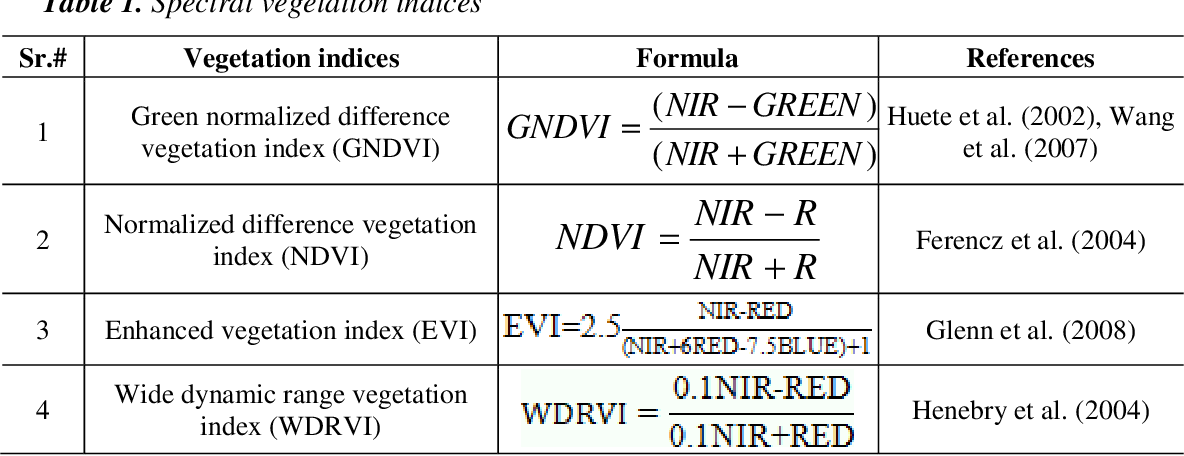

- For the same image above, calculate EVI and map it. Can you see any difference between EVI and NDVI?

In [ ]:
## Calculate and visualize EVI here...
EVI = NIR.subtract(Red).divide(NIR.add(Red.multiply(6).subtract(Blue.multiply(7.5).add(1)))).multiply(2.5)

### **Use Expressions**

So far, we use very brief operations, such as add, subtract, multiply, divide. However, some mathmetical equations can be more complicating and long to obtain any information you want to get. Therefore, to implement more complex mathematical expressions, it may be more convenient to use image.expression(), which parses a text representation of a math operation. The following example uses expression() to compute the Enhanced Vegetation Index (EVI):

In [ ]:
# Compute the EVI using an expression.
EVI = image.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
      'NIR': image.select('B5'),
      'RED': image.select('B4'),
      'BLUE': image.select('B2')
})

# Map = geemap.Map()
Map.addLayer(EVI, {'min': -1, 'max': 1, 'palette': palette}, 'EVI')
Map

Map(bottom=51171.0, center=[37.31993613728424, -122.02651779325119], controls=(WidgetControl(options=['positio…

As you can see in the previous cell, expression requires a few arguments

(1) Textual representation of the math operation: `2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))`

(2) Dictionary where the keys are variable names used in the expression and the values are the image bands to which the variables should be mapped: `{'NIR': image.select('B5'), 'RED': image.select('B4'), 'BLUE': image.select('B2')}`

***DO IT YOURSELF!!***
- You can see some other indices as well in this website: [Remote Sensing Indices](https://medium.com/regen-network/remote-sensing-indices-389153e3d947). Please try and visualize any index you want to calculate using expressions.

In [ ]:
# Try your own index here


## **2. Calculation between different images**

So far, we learn how to implement mathmatical operations for a single image to calculate vegetation indices. But we can also apply this mathmatical operations for two or more different images. For example, if you want to see how vegetation has changed between two different dates, you can calculate the differences of NDVI for these two images. Here, in this practice, you will calculate the difference of NDVI for two different dates. We are using another dataset named MODIS. Although MODIS has a coarse resoltuion (500 m - 1 km) compared to Landsat, it provides global scale observations for a large area with a daily time scale. The daily NDVI data from MODIS is available in GEE (16-days average). Please see the details of this dataset via this link: [MODIS Terra NDVI](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13A1#bands)

In [ ]:
# First NDVI image from winter (Jan 2020)
modis = ee.ImageCollection("MODIS/006/MOD13A1").filterDate('2020-01-01', '2020-01-31');

ndvi1 = modis.select('NDVI').first().multiply(0.0001);
# multiply scale factor (0.0001) because the NDVI value of MODIS data ranges 0-10000

In [ ]:
# Second NDVI image from summer (Jul 2020)
modis = ee.ImageCollection("MODIS/006/MOD13A1").filterDate('2020-07-01', '2020-07-31');

ndvi2 = modis.select('NDVI').first().multiply(0.0001);
# multiply scale factor (0.0001) because the NDVI value of MODIS data ranges 0-10000

In [ ]:
Map = geemap.Map()

Map.addLayer(ndvi1, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, "NDVI1")
Map.setCenter(-74, 40, 8);

Map

Map(center=[40, -74], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chi…

In [ ]:
Map = geemap.Map()

Map.addLayer(ndvi2, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, "NDVI2")
Map.setCenter(-74, 40, 8);

Map

Map(center=[40, -74], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chi…

In [ ]:
# Calculate difference of NDVI
ndvi_diff = ndvi2.subtract(ndvi1) # NDVI2 - NDVI1 -> changes of NDVI from Jan to Jul

In [ ]:
Map = geemap.Map()

Map.addLayer(ndvi_diff, {'min': -0.5, 'max': 0.5, 'palette': ['blue', 'white', 'red']}, "NDVI2")
Map.setCenter(-74, 40, 8);

Map

Map(center=[40, -74], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chi…

Please note that the `ndvi1` and `ndvi2` images have the same extent and spatial resolutions (from the same sensor).

## **3. Get image statistcis by region**

You are also able to calculate the statistics of image for a certain region of interst. Here we will calculate the NDVI values for a certain state/county and compare each state and county.

- US Census 2018 states data [LINK](https://developers.google.com/earth-engine/datasets/catalog/TIGER_2018_States)
- US Census 2018 counties data: [LINK](https://developers.google.com/earth-engine/datasets/catalog/TIGER_2018_Counties#table-schema)

In [ ]:
# See state feature collection
states = ee.FeatureCollection('TIGER/2018/States').filter(ee.Filter.lt("REGION", "9"))
# filter 50 states + DC

Map = geemap.Map()

Map.addLayer(states)
Map.centerObject(states, 4)
Map

Map(center=[45.16353981293477, -104.23634063385602], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# See Texas state feature
Texas = ee.FeatureCollection('TIGER/2018/States').filter(ee.Filter.eq("STATEFP", "48"))

Map = geemap.Map()

Map.addLayer(Texas)
Map.centerObject(Texas, 6)
Map

Map(center=[31.42680331716995, -99.28672202014272], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# See Texas counties feature collection
counties_TX = ee.FeatureCollection('TIGER/2018/Counties').filter(ee.Filter.eq("STATEFP", "48"))

Map = geemap.Map()

Map.addLayer(counties_TX)
Map.centerObject(counties_TX, 6)
Map

Map(center=[31.426803318664472, -99.28672202208742], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# See Bexar county feature collection
Bexar = ee.FeatureCollection('TIGER/2018/Counties').filter(ee.Filter.eq("NAME", "Bexar"))

Map = geemap.Map()

Map.addLayer(Bexar)
Map.centerObject(Bexar, 8)
Map

Map(center=[29.448823477328762, -98.51996281859623], controls=(WidgetControl(options=['position', 'transparent…

### **Reduceregion**

Now we will use `reduceRegion` function to extract the mean NDVI of Texas. [reduceRegion](https://developers.google.com/earth-engine/apidocs/ee-image-reduceregion)

In [ ]:
ndvi = ee.Image('MODIS/006/MOD13A1/2018_06_10').select("NDVI").multiply(0.0001)

ndvi_TX = ndvi.reduceRegion(
    geometry = Texas.geometry(),
    reducer = ee.Reducer.mean(),
    scale = 1000,
    maxPixels = 1e9
)

# Output of reduceRegion: ee.dictionary
print(ndvi_TX.getInfo()['NDVI'])

0.442277107652342


We can do the same thing for the Bexar County.

In [ ]:
ndvi = ee.Image('MODIS/006/MOD13A1/2018_06_10').select("NDVI").multiply(0.0001)

# reduceRegion function for Bexar County
ndvi_Bexar = ndvi.reduceRegion(
    geometry = Bexar.geometry(),
    reducer = ee.Reducer.mean(),
    scale = 1000,
    maxPixels = 1e9 # The maximum number of pixels to reduce (should be large enough to cover the entire Bexar County).
)

# Output of reduceRegion: ee.dictionary
print(ndvi_Bexar.getInfo()['NDVI'])

0.4993670342716705


### **Reduceregions**

If you want to compare multiple features in the feature collection, we can use `reduceRegions` function. [reduceRegions](https://developers.google.com/earth-engine/apidocs/ee-image-reduceregions) This function will allow us to extract the reduce results for multiple states or counties.

In [ ]:
# reduceRegions function: multiple states
ndvi_states = ndvi.reduceRegions(
    collection = states,
    reducer = ee.Reducer.median(),
    scale = 1000
)

# Output of reduceRegions: feature collection
# Convert the reduceregions result into pandas dataframe
df_ndvi_states = geemap.ee_to_df(ndvi_states)
df_ndvi_states.head(10)

,ALAND,AWATER,DIVISION,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,LSAD,MTFCC,NAME,REGION,STATEFP,STATENS,STUSPS,median
0,2677779902,1323670487,1,A,44,+41.5974187,-071.5272723,00,G4000,Rhode Island,1,44,01219835,RI,0.830095
1,23189413166,1026675248,1,A,33,+43.6726907,-071.5843145,00,G4000,New Hampshire,1,33,01779794,NH,0.869130
2,23874175944,1030416650,1,A,50,+44.0685773,-072.6691839,00,G4000,Vermont,1,50,01779802,VT,0.880856
3,12542497068,1815617571,1,A,09,+41.5798637,-072.7466572,00,G4000,Connecticut,1,09,01779780,CT,0.857434
4,79887426037,11746549764,1,A,23,+45.4092843,-068.6666160,00,G4000,Maine,1,23,01779787,ME,0.847679
5,20205125364,7129925486,1,A,25,+42.1565196,-071.4895915,00,G4000,Massachusetts,1,25,00606926,MA,0.824396
6,19047825980,3544860246,2,A,34,+40.1072744,-074.6652012,00,G4000,New Jersey,1,34,01779795,NJ,0.761809
7,115884442321,3394589990,2,A,42,+40.9024957,-077.8334514,00,G4000,Pennsylvania,1,42,01779798,PA,0.847648
8,122049149763,19246994695,2,A,36,+42.9133974,-075.5962723,00,G4000,New York,1,36,01779796,NY,0.855540
9,143780567633,6214824948,3,A,17,+40.1028754,-089.1526108,00,G4000,Illinois,2,17,01779784,IL,0.753901


In [ ]:
# reduceRegions function: multiple counties
ndvi_counties = ndvi.reduceRegions(
    collection = counties_TX,
    reducer = ee.Reducer.mean(),
    scale = 1000
)

# Output of reduceRegions: feature collection
df_ndvi_counties = geemap.ee_to_df(ndvi_counties)
df_ndvi_counties.head(10)

,ALAND,AWATER,CBSAFP,CLASSFP,COUNTYFP,COUNTYNS,CSAFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,LSAD,METDIVFP,MTFCC,NAME,NAMELSAD,STATEFP,mean
0,2727141729,23873001,27380,H1,073,01383822,540,A,48073,+31.8438807,-095.1563425,06,,G4020,Cherokee,Cherokee County,48,0.742363
1,2386603414,73164513,46340,H1,423,01383997,540,A,48423,+32.3751052,-095.2689389,06,,G4020,Smith,Smith County,48,0.713993
2,1312707008,1361884769,38920,H1,057,01383814,544,A,48057,+28.4417191,-096.5795739,06,,G4020,Calhoun,Calhoun County,48,0.486110
3,2284644914,17425944,47020,H1,469,01384020,544,A,48469,+28.7963699,-096.9711977,06,,G4020,Victoria,Victoria County,48,0.573051
4,2206698607,19050015,47020,H1,175,01383873,544,A,48175,+28.6607000,-097.4304145,06,,G4020,Goliad,Goliad County,48,0.564510
5,2269793029,611960874,13140,H1,245,01383908,,A,48245,+29.8539997,-094.1493306,06,,G4020,Jefferson,Jefferson County,48,0.604699
6,2418212542,15672146,13140,H1,351,01383961,,A,48351,+30.7867182,-093.7392500,06,,G4020,Newton,Newton County,48,0.747079
7,2306610690,18039522,13140,H1,199,01383885,,A,48199,+30.3296483,-094.3931782,06,,G4020,Hardin,Hardin County,48,0.747129
8,2279809496,246409,13300,H1,025,01383798,,A,48025,+28.4160769,-097.7425858,06,,G4020,Bee,Bee County,48,0.507795
9,2331552975,2245302,13700,H1,173,01383872,,A,48173,+31.8680062,-101.5214944,06,,G4020,Glasscock,Glasscock County,48,0.200037


In [ ]:
# Check the information for Bexar County
df_ndvi_counties[df_ndvi_counties["NAME"] == "Bexar"]

,ALAND,AWATER,CBSAFP,CLASSFP,COUNTYFP,COUNTYNS,CSAFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,LSAD,METDIVFP,MTFCC,NAME,NAMELSAD,STATEFP,mean
37,3212140683,41079712,41700,H1,029,01383800,,A,48029,+29.4486708,-098.5201465,06,,G4020,Bexar,Bexar County,48,0.499367


Now let's do the same thing for the MODIS land surface temperature data. [MODIS Terra Land Surface Temperature and Emissivity 8-Day Global 1km ](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD11A2)

In [ ]:
# Land surface temperature on June 10, 2018
temp = ee.Image("MODIS/061/MOD11A2/2018_06_10").select("LST_Day_1km").multiply(0.02)
# Multiply 0.02 to convert DN to K

# Multiple states
temp_states = temp.reduceRegions(
    collection = states,
    reducer = ee.Reducer.mean(),
    scale = 1000
)

# Output of reduceRegions: feature collection
df_temp_states = geemap.ee_to_df(temp_states)
df_temp_states.head(10)

,ALAND,AWATER,DIVISION,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,LSAD,MTFCC,NAME,REGION,STATEFP,STATENS,STUSPS,mean
0,2677779902,1323670487,1,A,44,+41.5974187,-071.5272723,00,G4000,Rhode Island,1,44,01219835,RI,298.697455
1,23189413166,1026675248,1,A,33,+43.6726907,-071.5843145,00,G4000,New Hampshire,1,33,01779794,NH,293.437098
2,23874175944,1030416650,1,A,50,+44.0685773,-072.6691839,00,G4000,Vermont,1,50,01779802,VT,293.556840
3,12542497068,1815617571,1,A,09,+41.5798637,-072.7466572,00,G4000,Connecticut,1,09,01779780,CT,299.099464
4,79887426037,11746549764,1,A,23,+45.4092843,-068.6666160,00,G4000,Maine,1,23,01779787,ME,293.952845
5,20205125364,7129925486,1,A,25,+42.1565196,-071.4895915,00,G4000,Massachusetts,1,25,00606926,MA,297.244065
6,19047825980,3544860246,2,A,34,+40.1072744,-074.6652012,00,G4000,New Jersey,1,34,01779795,NJ,300.669747
7,115884442321,3394589990,2,A,42,+40.9024957,-077.8334514,00,G4000,Pennsylvania,1,42,01779798,PA,298.345658
8,122049149763,19246994695,2,A,36,+42.9133974,-075.5962723,00,G4000,New York,1,36,01779796,NY,296.299578
9,143780567633,6214824948,3,A,17,+40.1028754,-089.1526108,00,G4000,Illinois,2,17,01779784,IL,302.724045


In [ ]:
# Multiple counties
temp_counties = temp.reduceRegions(
    collection = counties_TX,
    reducer = ee.Reducer.mean(),
    scale = 1000
)

# Output of reduceRegions: feature collection
df_temp_counties = geemap.ee_to_df(temp_counties)
df_temp_counties.head(10)

,ALAND,AWATER,CBSAFP,CLASSFP,COUNTYFP,COUNTYNS,CSAFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,LSAD,METDIVFP,MTFCC,NAME,NAMELSAD,STATEFP,mean
0,2727141729,23873001,27380,H1,073,01383822,540,A,48073,+31.8438807,-095.1563425,06,,G4020,Cherokee,Cherokee County,48,306.246841
1,2386603414,73164513,46340,H1,423,01383997,540,A,48423,+32.3751052,-095.2689389,06,,G4020,Smith,Smith County,48,306.678292
2,1312707008,1361884769,38920,H1,057,01383814,544,A,48057,+28.4417191,-096.5795739,06,,G4020,Calhoun,Calhoun County,48,307.421923
3,2284644914,17425944,47020,H1,469,01384020,544,A,48469,+28.7963699,-096.9711977,06,,G4020,Victoria,Victoria County,48,309.960547
4,2206698607,19050015,47020,H1,175,01383873,544,A,48175,+28.6607000,-097.4304145,06,,G4020,Goliad,Goliad County,48,310.977466
5,2269793029,611960874,13140,H1,245,01383908,,A,48245,+29.8539997,-094.1493306,06,,G4020,Jefferson,Jefferson County,48,306.085304
6,2418212542,15672146,13140,H1,351,01383961,,A,48351,+30.7867182,-093.7392500,06,,G4020,Newton,Newton County,48,303.443264
7,2306610690,18039522,13140,H1,199,01383885,,A,48199,+30.3296483,-094.3931782,06,,G4020,Hardin,Hardin County,48,303.860712
8,2279809496,246409,13300,H1,025,01383798,,A,48025,+28.4160769,-097.7425858,06,,G4020,Bee,Bee County,48,311.157986
9,2331552975,2245302,13700,H1,173,01383872,,A,48173,+31.8680062,-101.5214944,06,,G4020,Glasscock,Glasscock County,48,318.641181


### **Plot the relationship with NDVI v. temperature**

From this result, let's draw a plot to compare the relationships between NDVI and surface temperature.

In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'NDVI v. Temperature for TX counties')

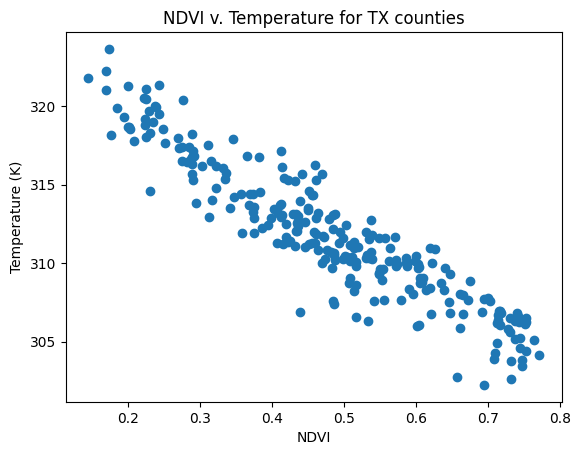

In [ ]:
plt.scatter(df_ndvi_counties['mean'], df_temp_counties['mean'])
plt.xlabel("NDVI")
plt.ylabel("Temperature (K)")
plt.title("NDVI v. Temperature for TX counties")

On the above scater plot, each point represent NDVI and LST for each county in Texas.

In [ ]:
plt.scatter(df_ndvi_states['mean'], df_temp_states['mean'])
plt.xlabel("Temperature (K)")
plt.ylabel("NDVI")
plt.title("NDVI v. Temperature for US states")

KeyError: 'mean'

Now let's draw the scatter plot between latitude and temperature to see if these two variables have any significant correlations.

In [ ]:
df_temp_states.head(10)

,ALAND,AWATER,DIVISION,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,LSAD,MTFCC,NAME,REGION,STATEFP,STATENS,STUSPS,mean
0,2677779902,1323670487,1,A,44,+41.5974187,-071.5272723,00,G4000,Rhode Island,1,44,01219835,RI,298.697455
1,23189413166,1026675248,1,A,33,+43.6726907,-071.5843145,00,G4000,New Hampshire,1,33,01779794,NH,293.437098
2,23874175944,1030416650,1,A,50,+44.0685773,-072.6691839,00,G4000,Vermont,1,50,01779802,VT,293.556840
3,12542497068,1815617571,1,A,09,+41.5798637,-072.7466572,00,G4000,Connecticut,1,09,01779780,CT,299.099464
4,79887426037,11746549764,1,A,23,+45.4092843,-068.6666160,00,G4000,Maine,1,23,01779787,ME,293.952845
5,20205125364,7129925486,1,A,25,+42.1565196,-071.4895915,00,G4000,Massachusetts,1,25,00606926,MA,297.244065
6,19047825980,3544860246,2,A,34,+40.1072744,-074.6652012,00,G4000,New Jersey,1,34,01779795,NJ,300.669747
7,115884442321,3394589990,2,A,42,+40.9024957,-077.8334514,00,G4000,Pennsylvania,1,42,01779798,PA,298.345658
8,122049149763,19246994695,2,A,36,+42.9133974,-075.5962723,00,G4000,New York,1,36,01779796,NY,296.299578
9,143780567633,6214824948,3,A,17,+40.1028754,-089.1526108,00,G4000,Illinois,2,17,01779784,IL,302.724045


In [ ]:
from scipy import stats
res = stats.linregress(df_temp_states['INTPTLAT'], df_temp_states['mean'])
res

LinregressResult(slope=-0.5183184804575935, intercept=323.57544989781576, rvalue=-0.49513573995795884, pvalue=0.00022087827245763822, stderr=0.1299277755927512, intercept_stderr=5.206118183813523)

In [ ]:
a = res.slope
b = res.intercept

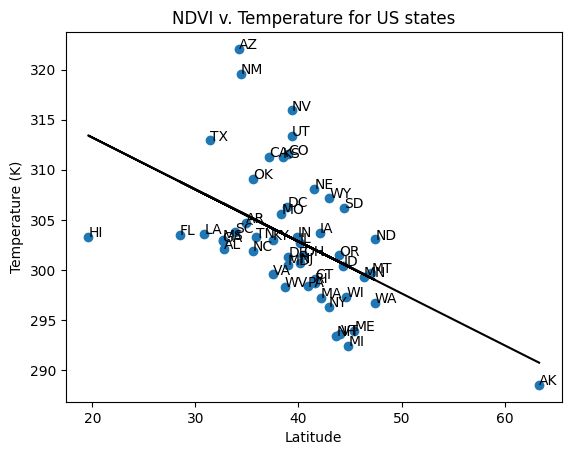

In [ ]:
# Convert datatype of latitude field (str -> float)
df_temp_states['INTPTLAT'] = df_temp_states['INTPTLAT'].astype(float)

plt.scatter(df_temp_states['INTPTLAT'], df_temp_states['mean'])
plt.xlabel("Latitude")
plt.ylabel("Temperature (K)")

# Linear regression line
plt.plot(df_temp_states['INTPTLAT'], a*df_temp_states['INTPTLAT'] + b, 'k')

plt.title("NDVI v. Temperature for US states")

# Indicate the name of each state
for i, txt in enumerate(df_temp_states['STUSPS']):
    plt.annotate(txt, (df_temp_states['INTPTLAT'][i], df_temp_states['mean'][i]))

## **4. Terrain Mapping**

Another very useful image data we can access in GEE is elevation data. We can also apply some mathmatical functions to these topographical data. We will use a very popular elevation data named SRTM: [SRTM Digital Elevation Data](https://developers.google.com/earth-engine/datasets/catalog/CGIAR_SRTM90_V4)

In [ ]:
# Import SRTM data
srtm = ee.Image('CGIAR/SRTM90_V4')

From the elevation data, we can two important terrain factors: (1) Slope [Slope function](https://developers.google.com/earth-engine/apidocs/ee-terrain-slope) and (2) Aspect [Aspect function](https://developers.google.com/earth-engine/apidocs/ee-terrain-aspect). Please watch this video to understand what they mean and how to derive these parameters from DEM. [Video: Slope and Aspect](https://www.youtube.com/watch?time_continue=129&v=_pbFnznqRAk&feature=emb_logo)

In [ ]:
# Calculate slope from the terrain data
slope = ee.Terrain.slope(srtm)

# Calculate aspect from the terrain data
aspect = ee.Terrain.aspect(srtm)

Map = geemap.Map()

Map.addLayer(aspect, {'min': 0, 'max': 360}, "Aspect")
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

***DO IT YOURSELF!!***
- By default, the slope is calculated as "degree", and the aspect is also calculated as "degree". Can you convert the slope into percentage (tangent percentage) and aspect into radians?
- Hint: use `tan` function for slope and `divide` or `multiply` for aspect.

In [ ]:
Map = geemap.Map()

Map.addLayer(srtm, {'min': 0, 'max': 1000}, "Elevation")
Map.setCenter(-74, 40, 8);

Map

Map(center=[40, -74], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chi…

In [ ]:
Map.addLayer(slope, {'max': 10}, "Slope")
Map.setCenter(-74, 40, 8);

Map

Map(bottom=1075.0, center=[40, -74], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

In [ ]:
Map.addLayer(aspect, {}, "Aspect")
Map.setCenter(-74, 40, 8);

Map

Map(bottom=1974.0, center=[40, -74], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

## **References**
- https://geemap.org/tutorials/#geemap-tutorials
- https://developers.google.com/earth-engine/apidocs/ee-image-reduceregions